# Statistical modelling and anomaly detection for pairwise user-host interactions

So far, we have been trying to detect compromised user credentials by performing anomaly detection at the user-day granularity.
However, we have faced a fundamental limitation of this approach: malicious activity is actually hard to detect from the point of view of a user, as it tends to be drowned in a majority of benign events.
Thus we have to zoom in and analyze activity at a finer scale.

In this notebook, we focus on pairwise interactions between users and hosts.
The main idea is to build a global model of these interactions so that we can predict the probability of a given user authenticating to a given host.
This model can then be used to detect anomalous authentication events.

In [20]:
import os
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hpfrec import HPF

from scipy.sparse import csr_matrix, dok_matrix, find
from scipy.stats import chi2, poisson

from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegressionCV

from utils import evaluate_algo, evaluate_algo_events

import warnings
warnings.simplefilter('ignore')

In [2]:
seed = 123
np.random.seed(seed)

In [3]:
dir_path = os.path.join('data', 'user_host_matrices')

The dataset essentially boils down to two rectangular matrices (one for the training period and one for the test period).
Each one of these matrices has $n$ rows and $m$ columns, where $n$ (resp. $m$) is the number of users (resp. hosts) in the dataset.
The coefficient at position $(i,j)$ is an integer representing the number of times the $i$-th user has logged on to the $j$-th host.
Note that these interaction matrices are sparse and can also be seen as weighted graphs.

In [4]:
train = pd.read_csv(                          # Read interaction matrix for the training period
    os.path.join(dir_path, 'train.csv')
)

test = pd.read_csv(                           # Read interaction matrix for the test period
    os.path.join(dir_path, 'test.csv')
)

users = pd.read_csv(                          # Read user index
    os.path.join(dir_path, 'users.csv'),
    index_col=0
)
user_idx = dict([(i, x['name']) for i, x in users.iterrows()])

hosts = pd.read_csv(                          # Read host index
    os.path.join(dir_path, 'hosts.csv'),
    index_col=0
)
host_idx = dict([(i, x['name']) for i, x in hosts.iterrows()])

First of all, let's see what the user-host authentication graph looks like.
A simple descriptive statistic is the degree distribution.

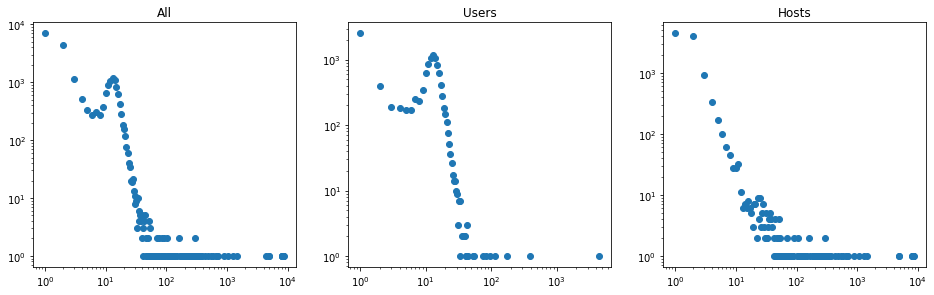

In [5]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(16, 4.5)
g = nx.Graph()
g.add_edges_from([
    (user_idx[x['UserId']], host_idx[x['ItemId']])
    for _, x in train.iterrows()])
axes[0].plot(nx.degree_histogram(g), ls='none', marker='o')
axes[0].loglog()
axes[0].set_title('All')
deg_users = np.unique(
    [g.degree(n) for n in g.nodes if n.startswith('U')],
    return_counts=True
    )
deg_hosts = np.unique(
    [g.degree(n) for n in g.nodes if n.startswith('C')],
    return_counts=True
    )
for i, d, t in zip((1, 2), (deg_users, deg_hosts), ('Users', 'Hosts')):
    axes[i].plot(d[0], d[1], ls='none', marker='o')
    axes[i].loglog()
    axes[i].set_title(t)
plt.show()

As expected, the overall degree distribution, as well as those for users and hosts only, roughly look like power laws.
This is a well-known property of many real-world networks.
However, a peculiar deviation from the trend appears for users around 10.
It actually makes sense given the nature of the data: we can typically expect most users to log on to approximately 10 hosts overall, including their workstation, domain controllers and a few applicative servers.
A small number of users should normally authenticate to many hosts, and we saw in the last notebook that a significant number of users log on to only one or two hosts.

Beyond the network structure of the user-host graph, another interesting aspect is the number of events associated with each edge, and also the proportion of malicious events in the set of events associated with a malicious edge (i.e., an edge containing at least one malicious event).

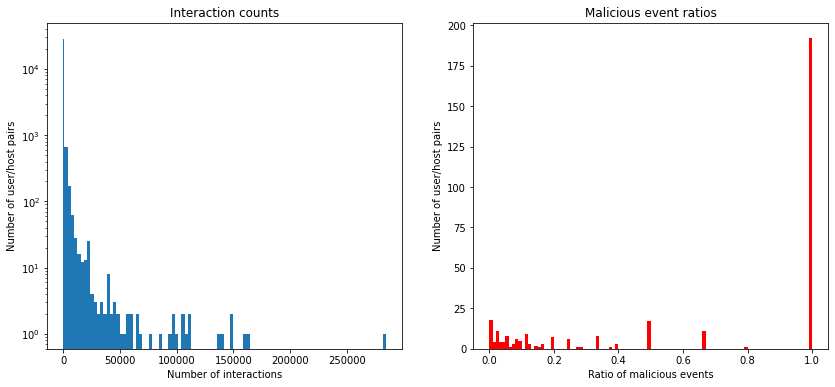

In [23]:
fig = plt.figure()
axes = fig.subplots(1, 2)
axes[0].hist(
    train['Count'],
    bins=np.concatenate([
        [0, 1],
        np.linspace(2, 100, 10),
        np.linspace(1000, train['Count'].max(), 100)
    ]),
    log=True)
axes[0].set_xlabel('Number of interactions')
axes[0].set_ylabel('Number of user/host pairs')
axes[0].set_title('Interaction counts')

malicious_ratios = test[test['Malicious']>0].apply(
    lambda x: x['Malicious']/x['Count'],
    axis=1)
axes[1].hist(malicious_ratios, bins=100, color='red')
axes[1].set_xlabel('Ratio of malicious events')
axes[1].set_ylabel('Number of user/host pairs')
axes[1].set_title('Malicious event ratios')

fig.set_size_inches(14, 6)
plt.show()

The number of events per edge has a long-tailed distribution, which is not too surprising.
User-host pairs yielding a very high number of events are probably related to automated activity.
As for malicious event ratios, they look much more favorable than in the previous notebooks: in particular, almost 200 user-host edges only contain malicious events in the test set.
It thus seems reasonable to think that malicious behavior should stand out more when aggregating events by user-host pair.

The main question is now the following: given a training matrix $\mathbf{A}\in\mathbb{R}^{n\times{m}}$ representing user-host interactions, how can we build a reliable model to predict future interactions?
A simple approach to that problem is matrix factorization: letting $d\geq{0}$ be a fixed hyperparameter, the matrix $\mathbf{A}$ can be approximated as $\mathbf{A}\approx\mathbf{U}\mathbf{V}^\top$, with $\mathbf{U}\in\mathbb{R}^{n\times{d}}$ and $\mathbf{V}\in\mathbb{R}^{m\times{d}}$.
Using this decomposition, we can then predict future interactions by studying reconstruction errors: given a user-host pair $(i,j)$, if $\mathbf{U}_i\mathbf{V}_j^\top$ is high whereas $\mathbf{A}_{ij}=0$, we can infer that $i$ and $j$ are likely to interact in the future even though they haven't so far.
The same idea can be used to detect anomalous interactions.

There are many different matrix factorization methods, and we start with a basic one, namely Non-negative Matrix Factorization (NMF).
As the name suggests, NMF constrains the coeffients of $\mathbf{U}$ and $\mathbf{V}$ to be non-negative.
The underlying idea is that each row of $\mathbf{A}$ can be approximated as a weighted sum of $m$-dimensional vectors taken from a dictionary with $d$ elements.
Each row of $\mathbf{U}$ can then be seen as a collection of weights, and making them non-negative means that reconstruction only works by adding elements (and not subtracting them).

In [7]:
def df_to_sparse_matrix(df, shape, rescale='none', bins=None):
    # Helper function.
    # If rescale == 'hist', then bins must be provided (array of bin
    # edges with bins[0] == 0 and bins.shape == number of bins).
    X = dok_matrix(shape)
    tot = df['Count'].sum()
    for _, x in df.iterrows():
        if rescale == 'log':
            cnt = np.log(1+x['Count'])/np.log(1+tot)
        elif rescale == 'hist':
            cnt = np.where(bins<x['Count']/tot)[0].max() + 1
        elif rescale == 'binary':
            cnt = int(x['Count']>0)
        else:
            cnt = x['Count']/tot
        X[x['UserId'], x['ItemId']] = cnt
    return csr_matrix(X)

def nmf_anomaly_scores(X, model, df):
    # Helper function.
    # X and df are a sparse matrix and a dataframe, respectively,
    # representing the same interactions.
    # model is a fitted NMF instance.
    X_rec = model.inverse_transform(model.transform(X))
    y_true = []
    y_pred = []
    for _, x in df.iterrows():
        y_true.append(int(x['Malicious']>0))
        i, j = x['UserId'], x['ItemId']
        y_pred.append(X[i, j]-X_rec[i, j])
    return np.array(y_true), np.array(y_pred)

def eval_nmf(train, test, n_comp, rescale='none', bins=None, seed=None):
    # Helper function.
    # train and test are dataframes representing user-host interactions.
    # n_comp is a tuple of integers; the i-th element of the tuple is the
    # number of components for the i-th evaluated NMF model.
    # rescale is the rescaling operation applied to the interaction counts
    # (among 'none', 'log', 'hist' and 'binary').
    # If rescale == 'hist', then bins must be provided.
    n_users = max(train['UserId'].max(), test['UserId'].max()) + 1
    n_hosts = max(train['ItemId'].max(), test['ItemId'].max()) + 1
    X_train = df_to_sparse_matrix(
        train,
        (n_users, n_hosts),
        rescale=rescale,
        bins=bins
    )
    X_test = df_to_sparse_matrix(
        test,
        (n_users, n_hosts),
        rescale=rescale,
        bins=bins
    )
    y_pred = []
    for k in n_comp:
        nmf = NMF(
            n_components=k,
            random_state=seed,
            init='nndsvd',
            alpha=.1,
            #l1_ratio=.5,
            max_iter=200).fit(X_train)
        y_test, y = nmf_anomaly_scores(X_test, nmf, test)
        y_pred.append(y)
    y_pred = np.stack(y_pred, axis=1)
    evaluate_algo(y_test, y_pred, names=['$d$={0}'.format(k) for k in n_comp])
    return y_test, y_pred

First of all, let's try to naively approximate the user-host interaction matrix.
The number of components (denoted $d$ above) cannot be determined a priori, so we try with several values.

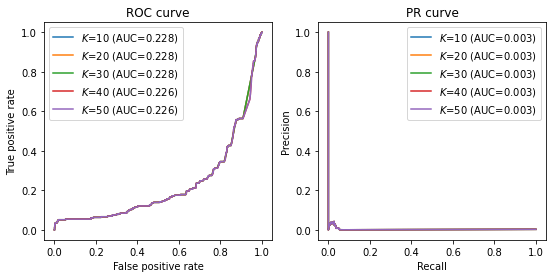

In [8]:
n_comp = (10, 20, 30, 40, 50)
y_test, y_pred = eval_nmf(train, test, n_comp, rescale='none', seed=seed)

That's absolutely terrible &mdash; what went wrong?
Here's a hint: the long-tailed distribution of the elements of the matrix (i.e., event counts) makes it hard to come up with a good factorization.
Moreover, the presence of a few extreme coefficients makes the loss function (i.e., the overall reconstruction error) depend heavily on these observations, preventing the learning algorithm from using the information contained in the rest of the matrix.

In order to alleviate this issue, we must somehow rescale the coefficients of the interaction matrices.
Let's try to do so by squashing them through a logarithmic function.

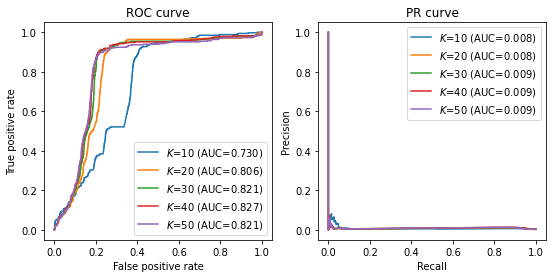

In [9]:
y_test, y_pred = eval_nmf(train, test, n_comp, rescale='log', seed=seed)

That's better, isn't it?
Let's see if more aggressive rescaling approaches can yield further improvements.
For instance, we can map the original values onto the first $K$ integers by building a histogram: given bin delimiters $0=b_0<b_1<\ldots<b_{K-1}<b_K=\infty$, each coefficient $\mathbf{A}_{ij}$ is replaced with the (unique) integer $k$ such that $b_{k-1}\leq\mathbf{A}_{ij}<b_k$.

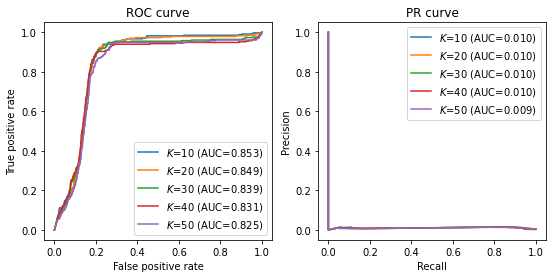

In [10]:
bins = np.array([0, 30000, 70000, 120000, 200000])/train['Count'].sum()
y_test, y_pred = eval_nmf(train, test, n_comp, rescale='hist', bins=bins, seed=seed)

Even better!
Finally, let's be even more aggressive and make the matrix binary &mdash; i.e., replace $\mathbf{A}_{ij}$ with $\mathbb{1}_{\{\mathbf{A}_{ij}>0\}}$.

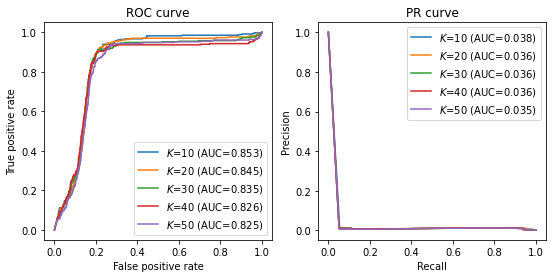

In [11]:
y_test, y_pred = eval_nmf(train, test, n_comp, rescale='binary', seed=seed)

Detection performance is roughly as good as when using a histogram.
From now on, we will thus always treat the interaction matrices as binary.

So far, we've evaluated our algorithms by trying to classify user-host pairs as benign or malicious.
What happens if we try to classify events instead?

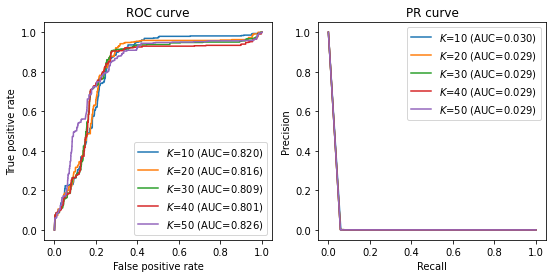

In [12]:
evaluate_algo_events(
    y_pred, test['Count'].to_numpy(), test['Malicious'].to_numpy(),
    names=['$K$={0}'.format(k) for k in n_comp]
)

That's not as good as what we obtained through user-based aggregation!
Let's try some other matrix factorization method.
More specifically, we're going to use a model that was originally proposed in the recommender systems literature.

Binary interactions frequently appear when analyzing user-item interactions in streaming or e-commerce services.
They correspond to so-called implicit feedback: the user either consumed the item or they didn't, and we don't necessarily have access to explicit ratings or interaction counts to make this knowledge more accurate.
The main challenge in this context is that we don't know whether an unobserved user-item interaction should be treated as negative implicit feedback, or simply as a possible future interaction.
This applies to some extent to the computer network monitoring problem: just because a user has never logged on to a given host doesn't mean they shouldn't.

To overcome this issue, Gopalan et al. proposed a model called Hierarchical Poisson Factorization (HPF&nbsp;[GHB15]).
Still considering a matrix $\mathbf{A}\in\{0,1\}^{n\times{m}}$ representing interactions between $n$ users and $m$ items, the generative model for $\mathbf{A}$ is the following:

* for each user $i\in\{1,\ldots,n\}$:
    * sample activity $\xi_i\sim\mathrm{Gamma}(a',a'/b')$;
    * for each component $k\in\{1,\ldots,d\}$, sample preference $\mathbf{U}_{ik}\sim\mathrm{Gamma}(a,\xi_i)$;
* for each item $j\in\{1,\ldots,m\}$:
    * sample popularity $\eta_j\sim\mathrm{Gamma}(c',c'/d')$;
    * for each component $k\in\{1,\ldots,d\}$, sample attribute $\mathbf{V}_{jk}\sim\mathrm{Gamma}(c,\eta_j)$;
* for each user $i$ and item $j$, sample feedback $\mathbf{A}_{ij}\sim\mathrm{Poisson}\big(\mathbf{U}_i\mathbf{V}_j^\top\big)$.

Note that this process can actually give values greater than 1 for each $\mathbf{A}_{ij}$, but fitting the model to implicit feedback matrices was empirically observed to yield good results.
The main idea here is that the model is hierarchical: it first samples a global rate parameter (activity $\xi_i$ for users and popularity $\eta_j$ for items), then uses this parameter to sample the latent factors $\mathbf{U}_i$ and $\mathbf{V}_j$.
This hierarchical nature allows the model to efficiently account for disparities in the number of interactions involving a given user or item, which seems appealing in the context of event log analysis.
HPF has thus already been used for intrusion detection in the literature&nbsp;[TMHM16].

Before moving on to the experiments, one last problem must be addressed, namely how to predict interactions for users and hosts which do not appear in the training set.
This is commonly referred to as the cold start problem in the recommender systems literature.
In the experiments we performed with NMF, we treated it by adding all-zero rows and columns to the training matrix.
However, this is obviously not optimal: the model then learns that the corresponding users and hosts are not supposed to interact at all, which has no reason to be true.
We thus explore two imputation methods here: the first one consists in sampling a random latent factor $\mathbf{U}_i$ (resp. $\mathbf{V}_j$) for each user (resp. host) which did not appear during training.
The second one consists in making these new latent factors equal to the mean of already existing ones; in other words, when a new user is observed, we initialize their latent factor to the mean of all existing users' latent factors.
Intuitively, the first method makes interactions involving new entities more anomalous than the second one.

In [13]:
def eval_hpf(train, test, n_comp, seed=None, imputation='mean'):
    df_train = train.loc[:,['UserId', 'ItemId', 'Count']]
    df_train['Count'] = [int(x>0) for x in df_train['Count'].to_numpy()]
    y_pred = []

    for k in n_comp:
        hpf = HPF(
            k=k, a=.5, a_prime=.5, c=.5, c_prime=.5, b_prime=50, d_prime=50,
            random_seed=seed, reindex=False, verbose=False)
        hpf.fit(df_train)
        
        add_users = test['UserId'].max() - train['UserId'].max()
        if imputation == 'mean':
            to_add = np.tile(hpf.Theta.mean(0), (add_users, 1))
        else:
            to_add = np.random.gamma(
                hpf.a,
                hpf.a_prime/hpf.b_prime,
                (add_users, k)).astype(hpf.Theta.dtype)
        hpf.Theta = np.concatenate([
            hpf.Theta,
            to_add
        ], axis=0)
        
        add_hosts = test['ItemId'].max() - train['ItemId'].max()
        if imputation == 'mean':
            to_add = np.tile(hpf.Beta.mean(0), (add_hosts, 1))
        else:
            to_add = np.random.gamma(
                hpf.c,
                hpf.c_prime/hpf.d_prime,
                (add_users, k)).astype(hpf.Beta.dtype)
        hpf.Beta = np.concatenate([
            hpf.Beta,
            to_add
        ], axis=0)
        y_pred.append(1-poisson.sf(
            1, hpf.predict(
            test['UserId'].to_numpy(),
            test['ItemId'].to_numpy()
        )))
    y_test = np.array([int(x>0) for x in test['Malicious'].to_numpy()])
    y_pred = np.stack(y_pred, axis=1)
    evaluate_algo(y_test, y_pred, names=['$d$={0}'.format(k) for k in n_comp])
    
    return y_test, y_pred

n_comp = (10, 30, 50, 75, 100)

Let's try random imputation first.
Once again, we test several values for the number of latent components $d$.

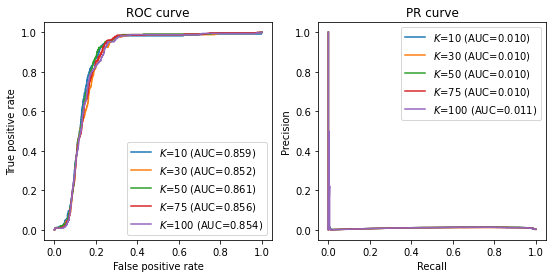

In [14]:
y_test, y_pred = eval_hpf(train, test, n_comp, seed=seed, imputation='random')

That's slightly better than what we got with NMF.
Let's see if averaging-based imputation yields any further improvement.

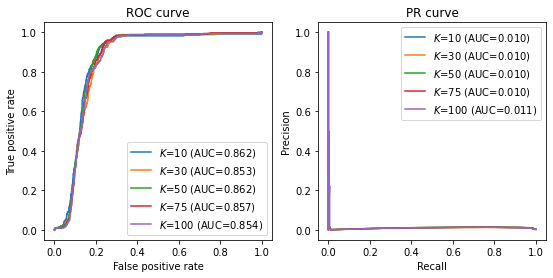

In [15]:
y_test, y_pred = eval_hpf(train, test, n_comp, seed=seed, imputation='mean')

The difference is mostly negligible; what about event-wise detection performance?

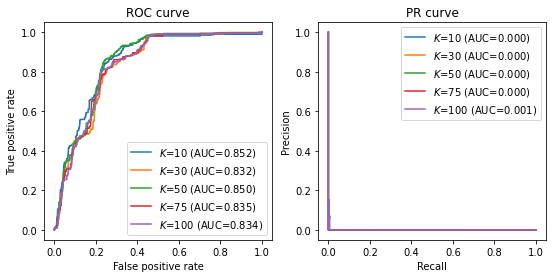

In [16]:
evaluate_algo_events(
    y_pred, test['Count'].to_numpy(), test['Malicious'].to_numpy(),
    names=['$K$={0}'.format(k) for k in n_comp]
)

We're still doing slightly worse than user-based aggregation.
Does that mean that we should just stick to the methods we saw in the first notebook?
Well, not necessarily.
First of all, recall that the low ratios of malicious events observed for malicious user-days raised concerns about a possible bias: outlying user accounts got compromised because they were interesting for intruders, but that does not mean that user-centric anomaly detection works in general.
Here, our approach seems more sensible: malicious user-host edges probably wouldn't be there without the red team.
Secondly, making finer-grained predictions allows us to do some postprocessing.

In particular, we know that intrusion-related activity is likely to generate clusters of events involving some shared users and hosts.
That knowledge can be used to eliminate some probable false positives: an edge with a high anomaly score between user $i$ and host $j$ should be considered more suspicious if there are other anomalous edges incident to $i$ or $j$.
In practice, we can apply this intuition by setting the score of each edge $(i,j)$ to

$\min\big(s(i,j),\max_{j'}s(i,j'),\max_{i'}s(i',j)\big)$,

where $s$ denotes the raw anomaly scoring function.

In [17]:
def chain_postproc(y_pred, test):
    g = nx.Graph()
    for j, x in test.iterrows():
        u, i = x['UserId'], x['ItemId']
        g.add_edge('U_{0}'.format(u), 'H_{0}'.format(i), score=y_pred[j])
    scores = test.loc[:,['UserId', 'ItemId']]
    scores.insert(2, 'Score', y_pred)
    usr_max = scores.groupby('UserId').max()
    itm_max = scores.groupby('ItemId').max()
    for u, x in usr_max.iterrows():
        ulab = 'U_{0}'.format(u)
        for ilab in g.neighbors(ulab):
            s = g.edges[(ulab, ilab)]['score']
            if s == x['Score']:
                i = int(ilab.split('_')[1])
                if s == itm_max.loc[i, 'Score']:
                    s1 = [g.edges[(ulab, v)]['score']
                          for v in g.neighbors(ulab)
                          if v != ilab]
                    s2 = [g.edges[(v, ilab)]['score']
                          for v in g.neighbors(ilab)
                          if v != ulab]
                    m1 = max(s1) if len(s1) > 0 else y_pred.min()
                    m2 = max(s2) if len(s2) > 0 else y_pred.min()
                    g.edges[(ulab, ilab)]['score'] = max(m1, m2)
    for j, x in test.iterrows():
        e = ('U_{0}'.format(x['UserId']), 'H_{0}'.format(x['ItemId']))
        y_pred[j] = g.edges[e]['score']

Let's see if this simple postprocessing improves detection performance.

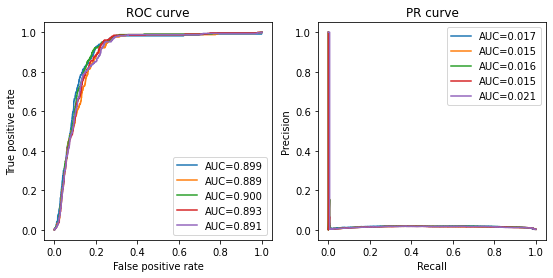

In [18]:
for j in range(y_pred.shape[1]):
    chain_postproc(y_pred[:,j], test)
evaluate_algo(y_test, y_pred)

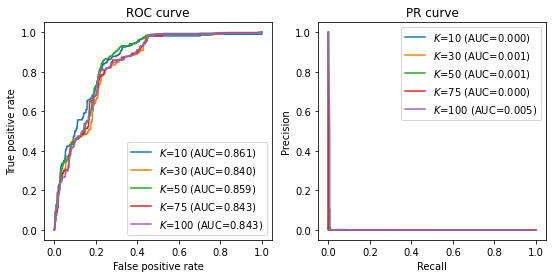

In [19]:
evaluate_algo_events(
    y_pred, test['Count'].to_numpy(), test['Malicious'].to_numpy(),
    names=['$K$={0}'.format(k) for k in n_comp]
)

There is indeed a sensible increase in detection performance.
However, this is still not satisfactory.
How can we improve the model?

Intuitively, one of the main weaknesses of the approach adopted in this notebook is that by representing authentication events as user-destination pairs, we lose a significant amount of information.
In particular, we would like to include the source host in order to detect users logging on to a usual destination from an unusual source.
This is especially relevant for the LANL dataset, in which the red team visited many hosts using the same source computer (C17693) as pivot.
However, modelling interactions involving more than two entities requires more complex mathematical objects than graphs and matrices.
This is the subject of the last notebook.

### Further reading

The idea of analyzing user-object access matrices for malicious behavior detection is nothing new.
Various kinds of objects have been considered in the literature, from files&nbsp;[CM11] through code repositories&nbsp;[HL13, MPRC17] to database tables&nbsp;[GKS$^+$19].
Applying this approach to user-host pairs thus appeared as a natural extension.
Note that the use of recommender systems to build fine-grained models of user-host interactions is rather recent: earlier work typically sought to detect anomalies at the user&nbsp;[CM11] or even network&nbsp;[HL13, MPRC17] granularity.

Recent advances on this subject include the apparition of time-sensitive models, which factor in the possibility of an interaction being normal inside certain periods only&nbsp;[GKS$^+$19, PTH21].
Some contributions have also explored graph link prediction methods other than matrix factorization, including node embedding-based approaches&nbsp;[BLJH20].


### References

[BLJH20] Benjamin Bowman, Craig Laprade, Yuede Ji, and H. Howie Huang. Detecting Lateral Movement in Enterprise Computer Networks with Unsupervised Graph AI. In _RAID_, 2020.

[CM11] You Chen and Bradley Malin. Detection of Anomalous Insiders in Collaborative Environments via Relational Analysis of Access Logs. In _CODASPY_, 2011.

[GHB15] Prem Gopalan, Jake Hofman, and David Blei. Scalable Recommendation with Hierarchical Poisson Factorization. In _UAI_, 2015.

[GKS$^+$19] Eyal Gutflaish, Aryeh Kontorovitch, Sivan Sabato, Ofer Biller, and Oded Sofer. Temporal Anomaly Detection: Calibrating the Surprise. In _AAAI_, 2019.

[HL13] Sébastien Heymann and Bénédicte Le Grand. Monitoring User-System Interactions through Graph-Based Intrinsic Dynamics Analysis. In _RCIS_, 2013.

[MPRC17] Pablo Moriano, Jared Pendleton, Steven Rich, and L. Jean Camp. Insider Threat Event Detection in User-System Interactions. In _MIST_, 2017.

[PTH21] Francesco Sanna Passino, Melissa Turcotte, and Nick Heard. Graph Link Prediction in Computer Networks Using Poisson Matrix Factorisation. _Annals of Applied Statistics_, to appear, 2021.

[TMHM16] Melissa Turcotte, Juston Moore, Nick Heard, and Aaron McPhall. Poisson Factorization for Peer-Based Anomaly Detection. In _ISI_, 2016.